
# Train/Test Split & Cross-Validation in scikit-learn — Classification & Time Series (No Pipelines)

**Level:** Entry → Middle  
**Goal:** Learn how to split data and validate models correctly for **classification** and **time series** tasks using scikit-learn — *without* Pipelines.

---

## What you'll learn
1. **Why** we split data into **train** and **test** sets.
2. How to use `train_test_split` for **classification** (with **stratify**).
3. How to use **K-Fold**/**StratifiedKFold** cross-validation.
4. How to handle **feature scaling safely _without_ Pipelines** during cross-validation.
5. For **time series**: chronological splits, **leak-free** lag/rolling features, and `TimeSeriesSplit`.


## 0) Setup

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

np.random.seed(42)  # reproducibility

# --- Helper: version-agnostic RMSE (works with old/new scikit-learn) ---
def rmse(y_true, y_pred):
    try:
        # Newer scikit-learn supports 'squared=False'
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # Older scikit-learn: compute sqrt of MSE manually
        return np.sqrt(mean_squared_error(y_true, y_pred))



---
## Part A — Classification (Entry → Middle)

We'll use the **Breast Cancer** dataset (binary classification) from scikit-learn.

### Steps
1. Load and inspect data.
2. Split with `train_test_split` (use `stratify=y` to keep class balance).
3. Train **Logistic Regression**; evaluate on the test set.
4. Do **5-fold Stratified CV** with `cross_val_score`.
5. Learn **leakage-free scaling** for algorithms that need it (e.g., **KNN**) **without Pipelines**.


### A.1) Load & Inspect

In [2]:

data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

print("X shape:", X.shape, "| y shape:", y.shape)
print("Classes:", dict(zip(data.target_names, np.bincount(y))))
print("First 3 feature names:", feature_names[:3])


X shape: (569, 30) | y shape: (569,)
Classes: {np.str_('malignant'): np.int64(212), np.str_('benign'): np.int64(357)}
First 3 feature names: ['mean radius' 'mean texture' 'mean perimeter']


### A.2) Split with `train_test_split` (stratified)

In [3]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (455, 30)  Test size: (114, 30)


### A.3) Train Logistic Regression and evaluate

In [4]:

# For small datasets, liblinear is a robust solver
logit = LogisticRegression(max_iter=5000, solver='liblinear', random_state=42)
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=data.target_names))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 0.9561, Precision: 0.9589, Recall: 0.9722, F1: 0.9655

Classification Report:
               precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix:
 [[39  3]
 [ 2 70]]


### A.4) 5-fold Stratified Cross-Validation

In [5]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    LogisticRegression(max_iter=5000, solver='liblinear', random_state=42),
    X, y, cv=skf, scoring='accuracy'
)
print("Stratified 5-fold CV Accuracy scores:", np.round(cv_scores, 4))
print("Mean CV Accuracy:", cv_scores.mean().round(4))


Stratified 5-fold CV Accuracy scores: [0.9386 0.9211 0.9561 0.9649 0.9646]
Mean CV Accuracy: 0.9491



### A.5) KNN with scaling **inside each fold** (no Pipeline)

This avoids **data leakage**: the scaler is **fit only on the training fold** and then applied to the validation fold.


In [6]:

def knn_cv_accuracy(X, y, n_neighbors=5, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)     # fit on training fold only
        X_val_s = scaler.transform(X_val)       # transform validation fold

        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_tr_s, y_tr)
        y_hat = knn.predict(X_val_s)
        scores.append(accuracy_score(y_val, y_hat))
    return np.array(scores)

scores_5 = knn_cv_accuracy(X, y, n_neighbors=5, n_splits=5)
print("KNN (k=5) Stratified 5-fold Accuracy:", np.round(scores_5, 4), " | Mean:", scores_5.mean().round(4))

# quick tune for k
means = {}
for k in [3,5,7,9,11]:
    s = knn_cv_accuracy(X, y, n_neighbors=k, n_splits=5).mean()
    means[k] = s
print("Mean CV accuracy by k:", {k: round(v,4) for k,v in means.items()})
best_k = max(means, key=means.get)
print("Best k by CV:", best_k)


KNN (k=5) Stratified 5-fold Accuracy: [0.9825 0.9474 0.9386 0.9825 0.9646]  | Mean: 0.9631
Mean CV accuracy by k: {3: np.float64(0.9666), 5: np.float64(0.9631), 7: np.float64(0.9649), 9: np.float64(0.9666), 11: np.float64(0.9631)}
Best k by CV: 9



---
## Part B — Time Series (Entry → Middle)

We'll create a simple **synthetic daily time series** (trend + seasonality + noise).  
Then we'll build **lag/rolling** features, do a chronological **train/test split**, fit baseline models, and use **TimeSeriesSplit** for CV.


### B.1) Create a daily series with trend + seasonality

In [7]:

# Synthetic daily series
idx = pd.date_range(start='2018-01-01', periods=1000, freq='D')
trend = 0.01 * np.arange(len(idx))
seasonal = 2 * np.sin(2*np.pi*idx.dayofyear/365.25)
noise = np.random.normal(scale=0.8, size=len(idx))
y = 20 + trend + seasonal + noise

df = pd.DataFrame({'y': y}, index=idx)
df.head()


,y
2018-01-01,20.431774
2018-01-02,19.968185
2018-01-03,20.641320
2018-01-04,21.385935
2018-01-05,20.024490


### B.2) Build **lag/rolling** features (leak-free)

In [8]:

# Use only **past** information
df['lag1'] = df['y'].shift(1)
df['lag7'] = df['y'].shift(7)
df['roll7_mean'] = df['y'].shift(1).rolling(window=7).mean()
df['roll7_std'] = df['y'].shift(1).rolling(window=7).std()

df_feat = df.dropna().copy()
features = ['lag1', 'lag7', 'roll7_mean', 'roll7_std']
X_all = df_feat[features]
y_all = df_feat['y']
X_all.shape, y_all.shape


((993, 4), (993,))

### B.3) Chronological train/test split (no shuffling)

In [9]:

split_idx = int(len(X_all) * 0.8)
X_train, X_test = X_all.iloc[:split_idx], X_all.iloc[split_idx:]
y_train, y_test = y_all.iloc[:split_idx], y_all.iloc[split_idx:]
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (794, 4)  Test: (199, 4)


### B.4) Train baseline models

In [10]:

lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

rmse_lin = rmse(y_test, pred_lin)
rmse_rf = rmse(y_test, pred_rf)

print(f"LinearRegression RMSE: {rmse_lin:.3f}")
print(f"RandomForestRegressor RMSE: {rmse_rf:.3f}")


LinearRegression RMSE: 0.800
RandomForestRegressor RMSE: 0.951


### B.5) Plot predictions on the test window

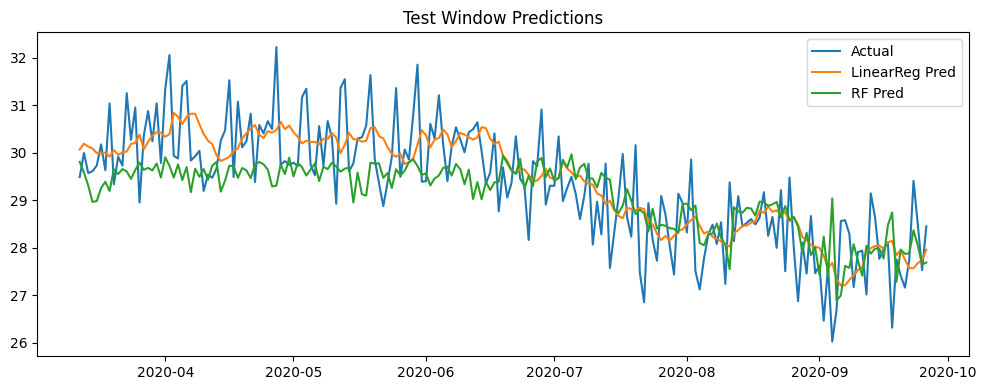

In [11]:

plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, pred_lin, label='LinearReg Pred')
plt.plot(y_test.index, pred_rf, label='RF Pred')
plt.title('Test Window Predictions')
plt.legend()
plt.tight_layout()
plt.show()


### B.6) Cross-validation with `TimeSeriesSplit`

In [12]:

tscv = TimeSeriesSplit(n_splits=5)
lin_rmse = []
rf_rmse = []

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_all), start=1):
    X_tr, X_val = X_all.iloc[tr_idx], X_all.iloc[val_idx]
    y_tr, y_val = y_all.iloc[tr_idx], y_all.iloc[val_idx]

    lin = LinearRegression().fit(X_tr, y_tr)
    rf = RandomForestRegressor(n_estimators=300, random_state=42).fit(X_tr, y_tr)

    pred_lin = lin.predict(X_val)
    pred_rf = rf.predict(X_val)

    lin_rmse.append(rmse(y_val, pred_lin))
    rf_rmse.append(rmse(y_val, pred_rf))

print("TimeSeriesSplit RMSE (Linear):", np.round(lin_rmse, 3), "| Mean:", np.mean(lin_rmse).round(3))
print("TimeSeriesSplit RMSE (RF):    ", np.round(rf_rmse, 3), "| Mean:", np.mean(rf_rmse).round(3))


TimeSeriesSplit RMSE (Linear): [0.83  1.034 0.86  0.854 0.806] | Mean: 0.877
TimeSeriesSplit RMSE (RF):     [0.909 2.78  0.915 2.342 0.864] | Mean: 1.562



---
## Wrap-up (Key Takeaways)

- **Classification:**
  - Use `train_test_split(..., stratify=y)` to preserve class balance.
  - For cross-validation on classification, prefer **StratifiedKFold**.
  - Some models need **scaled features** (e.g., KNN, SVM). Without Pipelines, **fit the scaler inside each fold** to avoid leakage.

- **Time Series:**
  - **Never shuffle** time; split chronologically.
  - Build features using only **past** values (`shift`, `rolling` with prior shift).
  - Use **TimeSeriesSplit** to respect temporal order.



---
## CHANGELOG (What was corrected)

- Fixed cells that mixed **Markdown text inside code cells** (caused syntax issues).
- Added **missing imports** and set `random_state=42` for reproducibility where relevant.
- Ensured **`stratify=y`** in `train_test_split` and added **evaluation metrics** for classification.
- Added a clear example of **KNN with scaling inside CV** (no Pipelines) to demonstrate **leak-free** preprocessing.
- Rewrote the **time series** section with leak-free lag/rolling features and proper **chronological** splits.
- Included **TimeSeriesSplit** evaluation and a simple **prediction plot**.
- Improved comments and headings for entry/middle-level students.
